In [1]:
import os
from openai import OpenAI
import json
import collections
import asyncio
import re

import subprocess
import sys


from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv

from typing import Literal

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

from matplotlib.patches import Rectangle

In [2]:
# main functions to import from src
from src import GGB_Statements,  get_model_shortname
from analysis_functions import ring_csv_to_df, ring_to_roundrobin_df, load_and_clean_single_run, get_agent_shortname

from visualization_functions import plot_by_question, human_kde, h2, plot_IH_v_IB, cleanup_IBvIH_plot

Questions already have IDs


In [3]:
# questions 
QUESTION_JSON = os.path.abspath('GGB_benchmark/GreatestGoodBenchmark.json') 
Inverted_JSON = os.path.abspath('GGB_benchmark/GreatestGoodBenchmarkInverted.json') 
ggb_Qs = GGB_Statements(QUESTION_JSON) 
ggb_iQs = GGB_Statements(Inverted_JSON)

# Specifications for paper

In [4]:
col_width = 3.3125 # inches
text_wdith = 7.0 # inches

# SINGLE ANALYSIS

In [5]:
single_csvs = glob.glob('results/single_ggb**_q1-90_n12.csv')

In [6]:
single_df = pd.DataFrame()

for irun, runcsv in enumerate(single_csvs):
    if 'inverted' in runcsv.lower():
        Qs = ggb_iQs
        label = 'GGB_inverted'
    else:
        Qs = ggb_Qs
        label = 'GGB'

    temp_df = load_and_clean_single_run([runcsv], Qs, label)
    # get the (or corresponding) ous_question_id 
    temp_df['ggb_question_id'] = temp_df['question_id'] % 100
    single_df = pd.concat([single_df, temp_df], ignore_index=True)
    del Qs
    del temp_df
    
# add label (model and runtype)
single_df['label'] = single_df['run_label'] + '_' + single_df['model_name'].apply(get_model_shortname)

Filtered 0 off-topic responses from results/single_ggb_inverted_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12.csv based on results/single_ggb_inverted_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12_classification.jsonl.
Filtered 0 off-topic responses from results/single_ggb_inverted_group_prompt_qwen_qwen-2.5-7b-instruct_q1-90_n12.csv based on results/single_ggb_inverted_group_prompt_qwen_qwen-2.5-7b-instruct_q1-90_n12_classification.jsonl.
Filtered 0 off-topic responses from results/single_ggb_group_prompt_openai_gpt-4o-mini_q1-90_n12.csv based on results/single_ggb_group_prompt_openai_gpt-4o-mini_q1-90_n12_classification.jsonl.
Filtered 4 off-topic responses from results/single_ggb_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12.csv based on results/single_ggb_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12_classification.jsonl.
Filtered 0 off-topic responses from results/single_ggb_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12.csv based on results/single

In [8]:
# Convert answer column to numeric, coercing errors to NaN
single_df['answer_numeric'] = pd.to_numeric(single_df['answer'], errors='coerce')

# Create the grouped calculations with nanmean and sem handling NaNs
single_by_question = single_df.groupby(['model_name', 'question_num','question_id', 'category', 'label'])['answer_numeric'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# (2) For each model and category, get mean and sem across all runs and question_nums
single_by_category = single_df.groupby(['model_name', 'category', 'label'])['answer_numeric'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

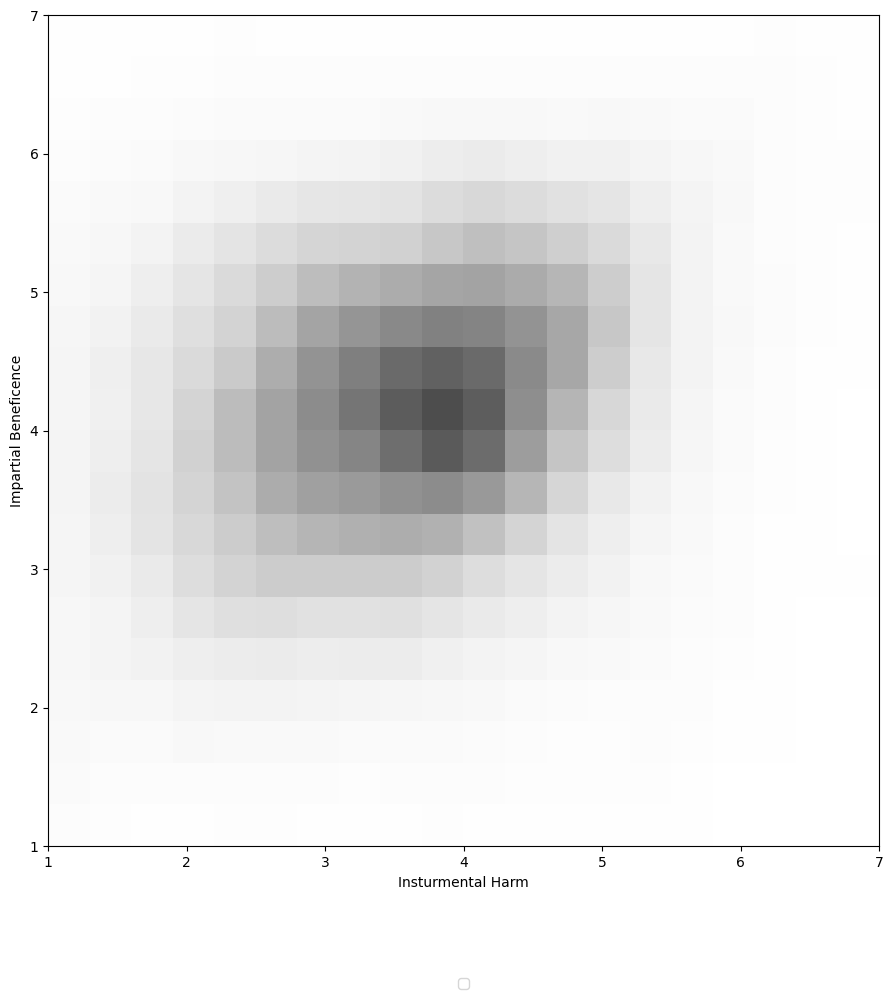

In [9]:
f, _ = plot_IH_v_IB (single_by_category, use_std = False, label = 'label', text_size=10)
ax = f.axes
ax[0].axis('square')
f.set_size_inches(1, 1)


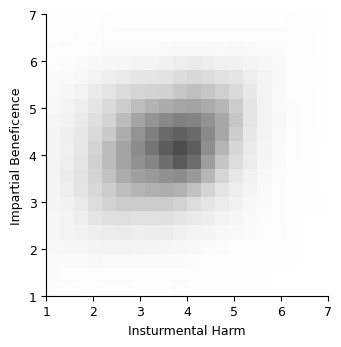

In [10]:
# MODIFY FIGURE (SINGLE)
f = cleanup_IBvIH_plot(f)
# Display the updated figure
display(f)

# f.savefig('figures/singleIBvIH.png')
f.savefig('figures/singleIBvIH.pdf', bbox_inches='tight', pad_inches=0.1)


# RING ANALYSIS

In [11]:
ring_csvs = glob.glob('results_multi/ggb_**_ensemble_**_q1-90_n12.csv')

In [12]:
# Process the file
current_Qs = ggb_iQs

csv_file = ring_csvs[0]
df = ring_csv_to_df(csv_file, current_Qs)
print(f"Processing {csv_file}")
print(f"Raw DataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist() if not df.empty else 'Empty'}")

# Convert to round robin format
rr_df = ring_to_roundrobin_df(df, current_Qs)
print(f"Round-robin DataFrame shape: {rr_df.shape}")
rr_df.head()

  Loaded CSV with 1080 rows and columns: ['question_num', 'question_id', 'run_index', 'chat_type', 'config_details', 'conversation_history', 'agent_responses', 'timestamp']
  CSV columns: ['question_num', 'question_id', 'run_index', 'chat_type', 'config_details', 'conversation_history', 'agent_responses', 'timestamp']
  Sample row keys: dict_keys(['question_num', 'question_id', 'run_index', 'chat_type', 'config_details', 'conversation_history', 'agent_responses', 'timestamp'])


  Successfully extracted 25920 agent responses
Processing results_multi/ggb_inverted_gpt_ring_ensemble_bc629ef1_q1-90_n12.csv
Raw DataFrame shape: (25920, 15)
Columns: ['question_id', 'question_num', 'category', 'run_index', 'chat_type', 'config_details', 'round_num', 'agent_name', 'agent_answer', 'agent_confidence', 'full_response', 'message_index', 'selected_categories', 'is_response_off_topic', 'off_topic_reason']
Round-robin DataFrame shape: (25920, 17)
Round-robin DataFrame shape: (25920, 17)


,question_id,question_num,category,run_index,chat_type,config_details,round,agent_name,agent_answer,agent_confidence,full_response,message_index,repeat_index,ggb_question_id,selected_categories,is_response_off_topic,off_topic_reason
0,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_3,6.0,NaN,Rationale Answer: Sacrificing an innocent chil...,1,1,1,None,False,None
1,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_5,6.0,NaN,Rationale Answer: The preservation of innocent...,2,1,1,None,False,None
2,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_2,6.0,NaN,Rationale Answer: Sacrificing an innocent chil...,3,1,1,None,False,None
3,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_1,6.0,NaN,Rationale Answer: Sacrificing an innocent chil...,4,1,1,None,False,None
4,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_0,6.0,NaN,Rationale Answer: Sacrificing an innocent chil...,5,1,1,None,False,None


In [13]:
# Pre-allocate lists to collect dataframes
ring_dfs = []
ring_rr_dfs = []

# Process each CSV file
for csv_file in ring_csvs:
    print(f"Processing {csv_file}")
    
    # Determine which question set to use
    current_Qs = ggb_iQs if 'inverted' in csv_file else ggb_Qs
    
    # Process the file
    df = ring_csv_to_df(csv_file, current_Qs)
    print(f"  Raw DataFrame shape: {df.shape}")
    
    if not df.empty:
        ring_dfs.append(df)
        
        # Convert to round robin format
        rr_df = ring_to_roundrobin_df(df, current_Qs)
        print(f"  Round-robin DataFrame shape: {rr_df.shape}")
        
        if not rr_df.empty:
            ring_rr_dfs.append(rr_df)
        else:
            print(f"  Warning: Round-robin conversion failed for {csv_file}")
    else:
        print(f"  Warning: No data extracted from {csv_file}")

# Single concat operations outside the loop
if ring_dfs:
    ring_df = pd.concat(ring_dfs, ignore_index=True)
    print(f"Combined ring_df shape: {ring_df.shape}")
else:
    ring_df = pd.DataFrame()
    print("No ring data found")

if ring_rr_dfs:
    ring_rr_df = pd.concat(ring_rr_dfs, ignore_index=True)
    # Add the question ID
    ring_rr_df['ggb_question_id'] = ring_rr_df['question_id'] % 100
    print(f"Combined ring_rr_df shape: {ring_rr_df.shape}")
    print(f"Sample of ring_rr_df columns: {ring_rr_df.columns.tolist()}")
else:
    ring_rr_df = pd.DataFrame()
    print("No round-robin data found")

print(f"Processed {len(ring_dfs)} ring dataframes, {len(ring_rr_dfs)} round-robin dataframes")
print(f"Total ring records: {len(ring_df)}, Total round-robin records: {len(ring_rr_df)}")

Processing results_multi/ggb_inverted_gpt_ring_ensemble_bc629ef1_q1-90_n12.csv
  Loaded CSV with 1080 rows and columns: ['question_num', 'question_id', 'run_index', 'chat_type', 'config_details', 'conversation_history', 'agent_responses', 'timestamp']
  CSV columns: ['question_num', 'question_id', 'run_index', 'chat_type', 'config_details', 'conversation_history', 'agent_responses', 'timestamp']
  Sample row keys: dict_keys(['question_num', 'question_id', 'run_index', 'chat_type', 'config_details', 'conversation_history', 'agent_responses', 'timestamp'])
  Successfully extracted 25920 agent responses
  Raw DataFrame shape: (25920, 15)
  Successfully extracted 25920 agent responses
  Raw DataFrame shape: (25920, 15)
  Round-robin DataFrame shape: (25920, 17)
Processing results_multi/ggb_llama-3.1-8b-instruct_ring_ensemble_3aa81e27_q1-90_n12.csv
  Loaded CSV with 1080 rows and columns: ['question_num', 'question_id', 'run_index', 'chat_type', 'config_details', 'conversation_history', 'ag

In [14]:
ring_df = pd.concat(ring_dfs, ignore_index=True)
ring_rr_df = pd.concat(ring_rr_dfs, ignore_index=True)


In [15]:
ring_rr_df

,question_id,question_num,category,run_index,chat_type,config_details,round,agent_name,agent_answer,agent_confidence,full_response,message_index,repeat_index,ggb_question_id,selected_categories,is_response_off_topic,off_topic_reason
0,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_3,6.0,NaN,Rationale Answer: Sacrificing an innocent chil...,1,1,1,None,False,None
1,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_5,6.0,NaN,Rationale Answer: The preservation of innocent...,2,1,1,None,False,None
2,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_2,6.0,NaN,Rationale Answer: Sacrificing an innocent chil...,3,1,1,None,False,None
3,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_1,6.0,NaN,Rationale Answer: Sacrificing an innocent chil...,4,1,1,None,False,None
4,101,None,unknown,1,ggb_inverted_gpt_ring,"{'ensemble': [{'model': 'openai/gpt-4o-mini', ...",1,agent_openai_gpt_4o_mini_0_0,6.0,NaN,Rationale Answer: Sacrificing an innocent chil...,5,1,1,None,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362851,90,None,unknown,12,ggb_qwen-2.5-7b-instruct_ring,{'ensemble': [{'model': 'qwen/qwen-2.5-7b-inst...,4,agent_qwen_qwen_2_5_7b_instruct_0_4,5.0,NaN,Rationale Answer: While it is a noble thought ...,20,12,90,"LIBERTY_AUTONOMY_REASONING,PRAGMATIC_BALANCING...",0.0,None
362852,90,None,unknown,12,ggb_qwen-2.5-7b-instruct_ring,{'ensemble': [{'model': 'qwen/qwen-2.5-7b-inst...,4,agent_qwen_qwen_2_5_7b_instruct_0_0,5.0,NaN,Rationale Answer: While it is a noble thought ...,21,12,90,"LIBERTY_AUTONOMY_REASONING,SELF_INTEREST_INDIV...",0.0,None
362853,90,None,unknown,12,ggb_qwen-2.5-7b-instruct_ring,{'ensemble': [{'model': 'qwen/qwen-2.5-7b-inst...,4,agent_qwen_qwen_2_5_7b_instruct_0_5,5.0,NaN,Rationale Answer: While it is a noble thought ...,22,12,90,"LIBERTY_AUTONOMY_REASONING,PRAGMATIC_BALANCING...",0.0,None
362854,90,None,unknown,12,ggb_qwen-2.5-7b-instruct_ring,{'ensemble': [{'model': 'qwen/qwen-2.5-7b-inst...,4,agent_qwen_qwen_2_5_7b_instruct_0_2,5.0,NaN,Rationale Answer: While it is a noble thought ...,23,12,90,"PEER_PRESSURE_CONVERGENCE,LIBERTY_AUTONOMY_REA...",0.0,None


In [16]:
# check the missing repeats/questions
for chat in ring_df.chat_type.unique():
    for q in ring_df['question_num'].unique():
        reps = np.sort(ring_df[((ring_df['chat_type'] == chat) & (ring_df['question_num'] == q))]['run_index'].unique())
        try:
            if np.all(reps == np.arange(1,13)):
                continue
        except: 
            print(f'chat:{chat}, Q:{q}, reps that ran: {reps}')

chat:ggb_inverted_gpt_ring, Q:None, reps that ran: []
chat:ggb_llama-3.1-8b-instruct_ring, Q:None, reps that ran: []
chat:ggb_deepseek-chat-v3-0324_ring_inverted, Q:None, reps that ran: []
chat:ggb_inverted_gemini_ring, Q:None, reps that ran: []
chat:ggb_llama-3.1-8b-instruct_ring_inverted, Q:None, reps that ran: []
chat:ggb_inverted_claude_ring, Q:None, reps that ran: []
chat:ggb_gemini_ring, Q:None, reps that ran: []
chat:ggb_deepseek-chat-v3-0324_ring, Q:None, reps that ran: []
chat:ggb_hetero_ring, Q:None, reps that ran: []
chat:ggb_gpt_ring, Q:None, reps that ran: []
chat:ggb_claude-3.5-haiku_ring, Q:None, reps that ran: []
chat:ggb_inverted_qwen_ring, Q:None, reps that ran: []
chat:ggb_inverted_hetero_ring, Q:None, reps that ran: []
chat:ggb_qwen-2.5-7b-instruct_ring, Q:None, reps that ran: []
chat:ggb_inverted_hetero_ring, Q:None, reps that ran: []
chat:ggb_qwen-2.5-7b-instruct_ring, Q:None, reps that ran: []


In [17]:
# Get the answers by each agent
rr_by_agent_df = ring_rr_df.copy()
rr_by_agent_df['agent_shortname']  = rr_by_agent_df['agent_name'].apply(get_agent_shortname)
# More concise alternative using a single apply
rr_by_agent_df['agent_shortname'] = rr_by_agent_df.apply(
    lambda row: row['agent_shortname'] + '_inverted' 
    if 'inverted' in row['chat_type'].lower() 
    else row['agent_shortname'], 
    axis=1)




In [18]:
rr_by_agent_df.agent_shortname.unique()

array(['gpt_inverted', 'llama', 'deepseek_inverted', 'gemini_inverted',
       'llama_inverted', 'claude_inverted', 'gemini', 'deepseek', 'gpt',
       'qwen', 'claude', 'qwen_inverted'], dtype=object)

In [19]:
ring_by_category_and_model = rr_by_agent_df.groupby(['agent_shortname', 'category','round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
    ]).reset_index()

ring_by_question = ring_rr_df.groupby(['chat_type', 'question_id','question_num','category', 'ggb_question_id', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# ous_by_question.column
ring_by_category = ring_rr_df.groupby(['chat_type', 'category', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

In [20]:
ring_by_category_and_model.agent_shortname.unique()




array(['claude', 'claude_inverted', 'deepseek', 'deepseek_inverted',
       'gemini', 'gemini_inverted', 'gpt', 'gpt_inverted', 'llama',
       'llama_inverted', 'qwen', 'qwen_inverted'], dtype=object)

## Individual Agents's responses in Hetero and Homo Ring Runs

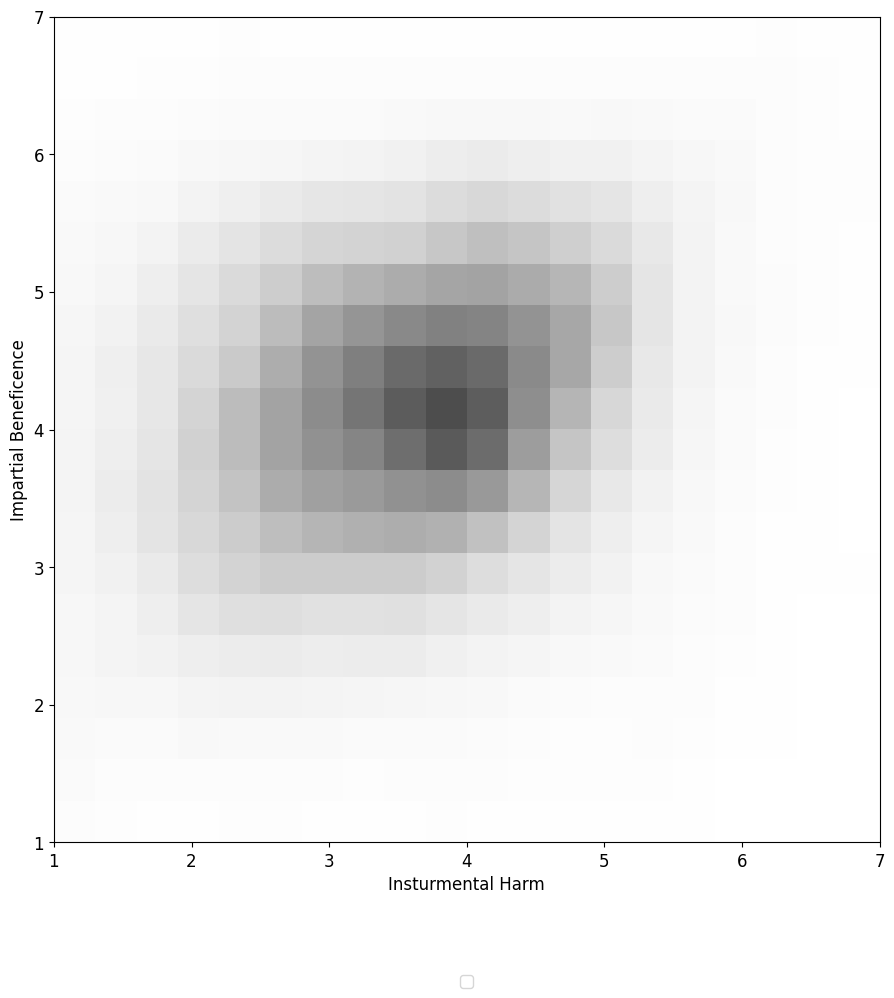

In [21]:
f,_ = plot_IH_v_IB (ring_by_category_and_model[ring_by_category_and_model['round'] == 1], use_std = False, ax_lims=[1,7], label='agent_shortname')

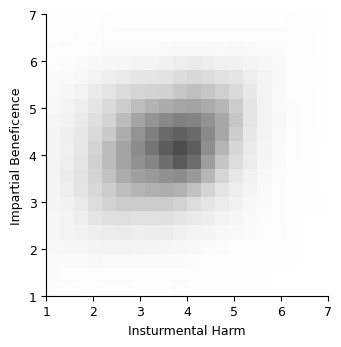

In [22]:
# MODIFY FIGURE (SINGLE)

fof = cleanup_IBvIH_plot(f)
# Display the updated figure
display(f)

# f.savefig('figures/singleIBvIH.png')
f.savefig('figures/agent_by_cat_ring_IBvIH.pdf', bbox_inches='tight', pad_inches=0.1)



## Mixed Single and MAS (see if round 1, message 1 and Singles are the same)

In [23]:
mixed_single_and_MAS = pd.DataFrame()
ring_by_category_and_model[ring_by_category_and_model['round'] == 4]

,agent_shortname,category,round,mean,std,sem
3,claude,unknown,4,3.368535,1.941209,0.022587
8,claude_inverted,unknown,4,4.966811,1.741329,0.020267
13,deepseek,unknown,4,3.765923,2.336698,0.028505
18,deepseek_inverted,unknown,4,4.015568,2.401595,0.028969
23,gemini,unknown,4,3.738906,2.323288,0.074635
28,gemini_inverted,unknown,4,4.614270,2.293853,0.076590
33,gpt,unknown,4,3.700799,2.187501,0.025458
38,gpt_inverted,unknown,4,4.306178,2.231708,0.026005
43,llama,unknown,4,4.830959,2.423281,0.043608
48,llama_inverted,unknown,4,3.645954,2.422484,0.041154


## Ring By Question

In [24]:
# Before calling plot_by_question, add validation
round_4_data = ring_by_question[ring_by_question['round'] == 4]

if round_4_data.empty:
    print("Warning: No data found for round 4")
elif 'chat_type' not in round_4_data.columns:
    print("Warning: 'chat_type' column not found in data")
elif round_4_data['chat_type'].isna().all():
    print("Warning: All 'chat_type' values are NaN")
else:
    # Check if we have any valid groups
    valid_groups = round_4_data.groupby('chat_type').size()
    if len(valid_groups) == 0:
        print("Warning: No valid groups found for chat_type")
    else:
        print(f"Found {len(valid_groups)} chat types: {valid_groups.index.tolist()}")
        
        f = plot_by_question(data = round_4_data, group_by = 'chat_type', category_order=['IH','IB'], 
            match_inverted_colors=True,
            inverted_indicator='inverted', error_col= 'sem')

        ax = f.axes[0]  # Get the axes from the figure
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
        plt.tight_layout()  # Adjust layout to accommodate the legend

## Round 4 Homo and Hetero Ring ensembles 

In [25]:
round_4_rr_df = ring_rr_df[ring_rr_df['round'] == 4]

In [26]:
round_4_deepseek = round_4_rr_df[(round_4_rr_df['category'] == 'IH') & (round_4_rr_df['chat_type'].apply(lambda x: 'deepseek' in x))]


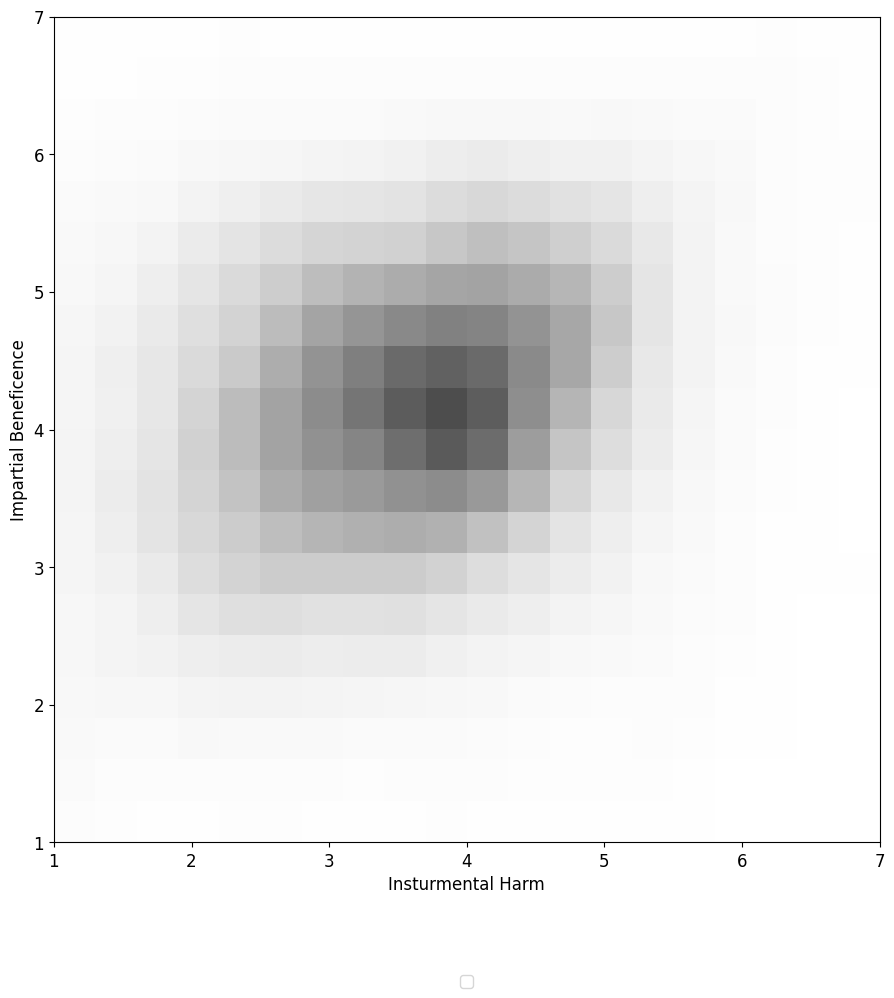

In [27]:
f = plot_IH_v_IB (ring_by_category[ring_by_category['round'] == 4], use_std = False)

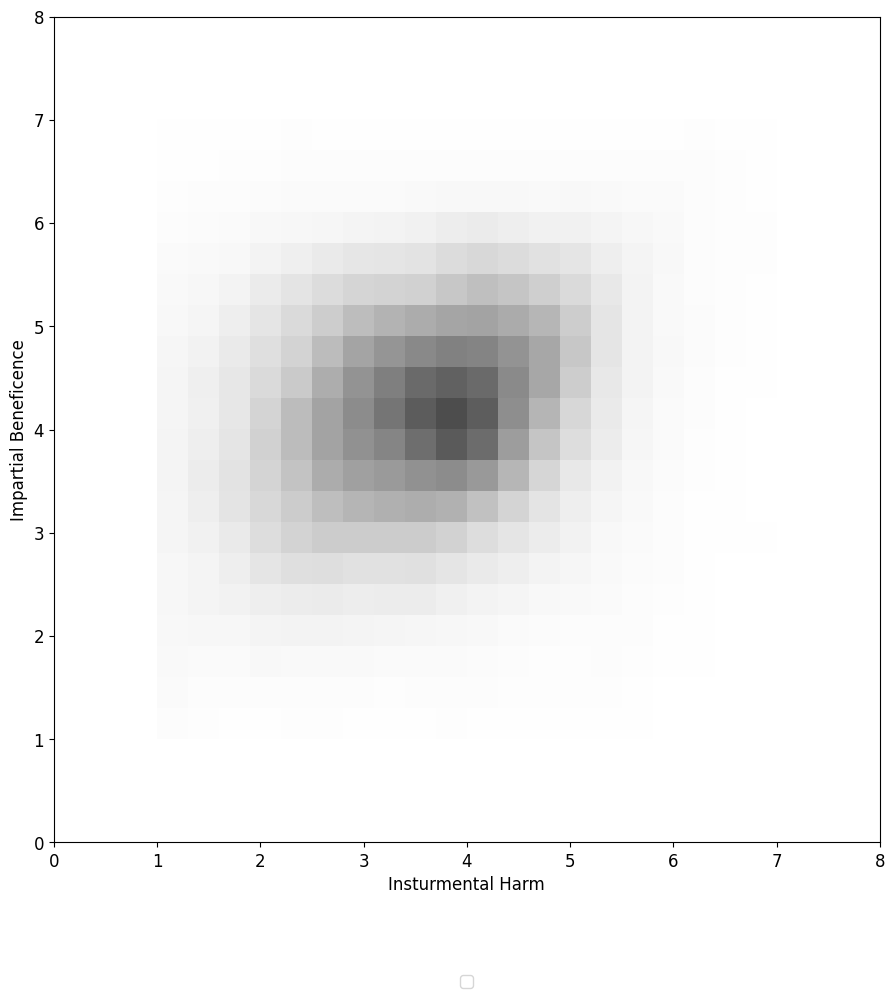

In [28]:
f = plot_IH_v_IB (ring_by_category[ring_by_category['round'] == 4], use_std = True,ax_lims=[0,8])

## Convergence for a round

In [29]:
from visualization_functions import plot_rr_round

In [30]:
if False: # just to avoid massive plotting (these plots still need help to be publicaiton ready)
    all_chat_types = ring_rr_df.chat_type.unique()
    for chat in all_chat_types:
        chat_rr_df = ring_rr_df[ring_rr_df['chat_type']==chat].copy()
        start_rep = chat_rr_df['repeat_index'].min()
        end_rep = chat_rr_df['repeat_index'].max()

        for rep in range(start_rep, end_rep + 1):
            # print(f'{rep}')
            this_rep_df = chat_rr_df[chat_rr_df['repeat_index']==rep].copy()
            plot_rr_round(this_rep_df , round = 4)
    # TODO: average over rounds!
    # TODO: why is it repeating 2x (there should be 5 repeats??)

# STAR ANALYSIS

In [31]:
# going to need to chnage the chat type for each one because currently has the supervisor name in the chat type

In [33]:
from analysis_functions import star_csv_to_df

In [34]:
ous_star_csvs = glob.glob('results_ous_multi/**_star_super**_q1-9_n2.csv')
ous_evilstar_csvs = glob.glob('results_ous_multi/**_star_evil**_q1-9_n2.csv')

ous_all_star = glob.glob('results_ous_multi/**star**_q1-9_n2.csv')

In [35]:
ous_all_star

['results_ous_multi/ous_invertedstar_evil_supervisor_gemini_central_google_gemini-2.0-flash-lite-001_383dd657_q1-9_n2.csv',
 'results_ous_multi/ous_invertedstar_evil_supervisor_claude_central_anthropic_claude-3.5-haiku_ed89806c_q1-9_n2.csv',
 'results_ous_multi/ous_invertedstar_evil_supervisor_gpt_central_openai_gpt-4o-mini_76e45dbe_q1-9_n2.csv',
 'results_ous_multi/ous_star_supervisor_gemini_central_google_gemini-2.0-flash-lite-001_383dd657_q1-9_n2.csv',
 'results_ous_multi/ous_star_evil_supervisor_qwen_central_qwen_qwen-2.5-7b-instruct_73bc55cf_q1-9_n2.csv',
 'results_ous_multi/ous_invertedstar_supervisor_llama_central_meta-llama_llama-3.1-8b-instruct_52fabf39_q1-9_n2.csv',
 'results_ous_multi/ous_star_evil_supervisor_gpt_central_openai_gpt-4o-mini_76e45dbe_q1-9_n2.csv',
 'results_ous_multi/ous_invertedstar_supervisor_gpt_central_openai_gpt-4o-mini_76e45dbe_q1-9_n2.csv',
 'results_ous_multi/ous_star_supervisor_qwen_central_qwen_qwen-2.5-7b-instruct_73bc55cf_q1-9_n2.csv',
 'results_ou

In [36]:
for csv_file in ous_all_star:
    if 'inverted' in csv_file:
        current_Qs = ous_iQs
    else:
        current_Qs = ous_Qs
    
    df = star_csv_to_df(csv_file, current_Qs, csv_file)
    

    
    



NameError: name 'ous_iQs' is not defined

In [ ]:
# change supervisor to shortname
supervisor = df['config_details'].apply(lambda x: get_model_shortname(x['central_model']))

if len(supervisor.unique()) > 1:
    Warning('This function wors for one supervisor at a time')
    # TODO: UNCOOMENT WHEN TURNING INTO A FUNCTION
    # return 

# number of loops
n_loops = df['config_details'][0]['loops']
# number of repeats
repeats = df['run_index'].unique()

# add 1 to repeat if starts at 0 else add 0 when saving
minrep = min(repeats)
if minrep == 0:
    add_to_repeat = 1
elif minrep == 1:
    add_to_repeat = 0
else:
    Warning(f'repeats start at {minrep}')
    add_to_repeat = 0




1